# Formulation du problème

Soit $X \in \mathbb{R}^{m \times n}$ une matrice de count où $n$ est le nombre d'échantillon et $m$ est le nombre de gènes. On cherche à déterminer $K \in \mathbb{N}^*$ prototypes.

On suppose que l'on a une matrice $M \in \{0,1\}^{m \times k}$ où $k\leq K$ est le nombre de prototypes sur lesquels on pose un a priori. On cherche à résoudre le problème suivant :

$$ W^*,H^* = \arg\min_{H \in \mathbb{R}^{n \times K}_{+} ; W \in \mathbb{R}^{m \times K}} \text{dst}_X(WH) + \lambda g_M(W)$$


où l'on a :
$$\text{dst}_X(WH) = \frac{1}{2mn}|| WH - X||_F^2$$
$$g_M(W) =  \frac{1}{2mk} ||W[:,:k] \odot (1-M)||_F^2 = \frac{1}{2mk}\sum_{i=1}^{m} \sum_{j=1}^{k} W_{ij}^2 (1-M_{ij}) \$$
<!-- $$E = \{H \in \mathbb{R}^{n \times K} | H \succeq 0 ; \sum_{i=1}^{K} H_{ij} = 1\}$$ -->

La régularisation permet d'assurer que les poids des gènes marqués comme non pertinents soient faibles. De fait pour assurer une bonne reconstruction de la matrice $X$, les gènes marqués devront compenser et avoir un poids plus important. Pour interpréter $H$ comme des probabilités, après entrainement, on peut normaliser les lignes de $H$.
On peut sans problème changer l'espace de $W$ de $\mathbb{R}^{m \times K}$ à $\mathbb{R}^{m \times K}_{+}$ qui est aussi un convexe compact.

Remarque : On ne peut pas normaliser H pendant l'entrainement sans devoir rajouter un facteur d'échelle, autant normaliser à la fin.

Remarque 2 : On peut aussi rajouter une contrainte sur les magnitudes des poids de W avec une norme L1 ou L2 (~weight decay).
 <!-- La contrainte de normalisation de $H$ permet d'interpéter les poids comme des probabilités. -->

# Méthode de résolution

On remarque d'abord que les contraintes sont bien des ensembles convexes non-vides. Ensuite on remarque que la fonction objectif est convexe en $H$ et $W$ mais pas en $H$ et $W$ simultanément. On peut alors utiliser une méthode de descente de gradient alternée projetée. On aura convergence vers un point stationnaire de la fonction objectif.


On commence par initialiser $H$ et $W$ aléatoirement mais valides. On calcule ensuite les gradients de $H$ et $W$ par rapport à la fonction objectif. On update les matrices puis on projette ensuite les données sur les contraintes de $H$ et $W$.

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd
from scipy.stats import spearmanr
from datetime import datetime

In [2]:
def loss_fn(X, W, H, M, l=0):
    reco_loss = 0.5 * 1 / X.numel() * torch.linalg.norm(W @ H - X, "fro") ** 2
    k = M.shape[1]
    prior_loss = 0.5 * 1 / M.numel() * torch.linalg.norm(W[:, :k] * torch.logical_not(M), "fro") ** 2
    loss = reco_loss + l * prior_loss
    return loss, reco_loss, prior_loss


def projection(H, normalize=True):
    # project H onto the non-negative orthant
    H_proj = torch.clamp(H, 0)
    # normalize H so that the row sums to one
    if normalize:
        H_proj = H_proj / H_proj.sum(0)
    return H_proj

In [3]:
def initialize_W_H_rand(m, n, K, normalize=False, X=None):
    scale = np.sqrt(X.mean() / K) if X is not None else 1
    W = torch.rand(int(m), int(K), requires_grad=True, dtype=torch.double) * scale
    H = torch.rand(int(K), int(n), requires_grad=True, dtype=torch.double) * scale
    # Point initial doit être valide
    H.data = projection(H.data, normalize=normalize)
    return W, H


def initialize_W_H_sklearn(m, n, K, X, normalize=False):
    nmf = NMF(n_components=K, init="random", random_state=0, verbose=False)
    W_sklearn = nmf.fit_transform(X)
    H_sklearn = nmf.components_
    W = torch.tensor(W_sklearn, requires_grad=True, dtype=torch.double)
    H = torch.tensor(H_sklearn, requires_grad=True, dtype=torch.double)
    H.data = projection(H.data, normalize=normalize)
    return W, H


def initialize_W_H_nndsvd(m, n, K, X, normalize=False, eps=1e-6, random_state=1312):
    # Code blatantly copied from scikit-learn
    # NNDSVD initialization
    X_ = X.numpy()
    U, S, V = randomized_svd(X_, K, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, K):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = np.linalg.norm(x_p), np.linalg.norm(y_p)
        x_n_nrm, y_n_nrm = np.linalg.norm(x_n), np.linalg.norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    W = torch.tensor(W, requires_grad=True, dtype=torch.double)
    H = torch.tensor(H, requires_grad=True, dtype=torch.double)
    H.data = projection(H.data, normalize=normalize)
    return W, H


def initialize_W_H(m, n, K, normalize=False, type="rand", X=None):
    if type == "random":
        W, H = initialize_W_H_rand(m, n, K, normalize)
    elif type == "sklearn":
        W, H = initialize_W_H_sklearn(m, n, K, X)
    elif type == "nndsvd":
        W, H = initialize_W_H_nndsvd(m, n, K, X)
    else:
        raise ValueError(f"type must be 'random' or 'sklearn' or 'nnsvd', got {type}")
    H = H.clone().detach().requires_grad_(True)
    W = W.clone().detach().requires_grad_(True)
    return W, H

In [4]:
def plot_training(loss_list, reco_loss_list, prior_loss_list, learning_rate_list_H, learning_rate_list_W):
    _, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].plot(loss_list)
    ax[0].set_title("Total loss")
    ax[1].plot(reco_loss_list)
    ax[1].set_title("Reconstruction loss")
    ax[2].plot(prior_loss_list)
    ax[2].set_title("Prior loss")
    ax[3].plot(learning_rate_list_H, label="H")
    ax[3].plot(learning_rate_list_W, label="W")
    ax[3].set_title("Learning rate")

    for axis in ax[:-1]:
        axis.set_xlabel("Iteration")
        axis.set_ylabel("Loss")
        axis.set_yscale("log")
    plt.show()

# Alternate Projected Gradient Descent on synthetic data

In [5]:
# Create random data for the sake of the example. X from poisson
n, m, K, k = int(20_000), int(20_000), 50, 5  # -> realistic full size count matrix
n, m, K, k = int(1e3), int(1e3), 50, 5  # -> simple small size count matrix
scale = 400
X = torch.poisson(torch.ones(int(m), int(n), dtype=torch.double) * scale)
M = torch.rand(int(m), int(k)) > 0.5
M_tilde = torch.cat((M, torch.ones(int(m), int(K - k))), 1)
X.std(), X.mean()

(tensor(19.9792, dtype=torch.float64), tensor(399.9894, dtype=torch.float64))

In [6]:
# plt.hist(X.flatten(), bins=100)
# plt.show()

In [7]:
# Declare the variables as parameters
W, H = initialize_W_H(m, n, K, type="random", X=X)
# Optimize
l = 10  # Regularization parameter, set to 0 to not use it
learning_rate_H = learning_rate_W = 1
n_iter = 500
n_iter_H = n_iter_W = 1
optimizer_H = torch.optim.Adam([H], lr=learning_rate_H)
optimizer_W = torch.optim.Adam([W], lr=learning_rate_W)
scheduler_H = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_H, T_max=n_iter, eta_min=0.001)
scheduler_W = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_W, T_max=n_iter, eta_min=0.001)

In [8]:
loss_list = []
reco_loss_list = []
prior_loss_list = []
learning_rate_list_H = []
learning_rate_list_W = []

# dont go on gpu, doesnt converge -> to be tested further
# W = W.to("cuda")
# H = H.to("cuda")
# X = X.to("cuda")
# M = M.to("cuda")
# M_tilde = M_tilde.to("cuda")

pbar = tqdm(range(n_iter), desc="Training")
for t in pbar:

    for iter_h in range(n_iter_H):
        optimizer_H.zero_grad()
        loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
        loss.backward()
        optimizer_H.step()
        # H.data = projection(H.data, normalize=True)
        H.data = projection(H.data, normalize=False)

    for iter_w in range(n_iter_W):
        optimizer_W.zero_grad()
        loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
        loss.backward()
        optimizer_W.step()
        W.data = projection(W.data, normalize=False)  # -> comment this line to allow for negative weights

    scheduler_H.step()
    scheduler_W.step()

    # Logging
    loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
    loss_list.append(loss.item())
    reco_loss_list.append(reco_loss.item())
    prior_loss_list.append(prior_loss.item())
    learning_rate_list_H.append(scheduler_H.get_last_lr()[0])
    learning_rate_list_W.append(scheduler_W.get_last_lr()[0])
    pbar.set_postfix(
        {
            "loss": loss.item(),
            "reconstruction error": reco_loss.item(),
            "prior loss": prior_loss.item(),
            "learning rate H": scheduler_H.get_last_lr()[0],
            "learning rate W": scheduler_W.get_last_lr()[0],
        }
    )

print("Final loss:", loss.item())
print(f"Final reconstruction error: {reco_loss.item()}")

Training: 100%|██████████| 500/500 [00:13<00:00, 36.47it/s, loss=182, reconstruction error=182, prior loss=0.0022, learning rate H=0.001, learning rate W=0.001]     

Final loss: 182.28135111261062
Final reconstruction error: 182.25930133910165


In [9]:
print("Average weights magnitude on markers:", W[:, :k][M].mean().item())
print("Average weights magnitude on non-markers:", W[:, :k][~M].mean().item())

Average weights magnitude on markers: 5.620542046511555
Average weights magnitude on non-markers: 0.07014174133850697


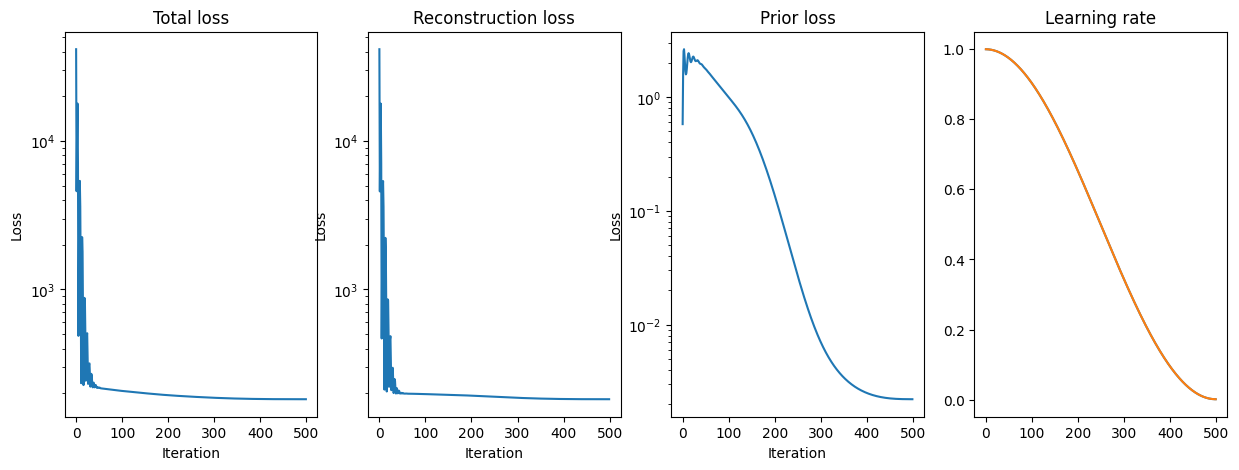

In [10]:
plot_training(loss_list, reco_loss_list, prior_loss_list, learning_rate_list_H, learning_rate_list_W)

# Compare with sklearn NMF

In [11]:
nmf = NMF(n_components=K, init="random", random_state=0, verbose=False)
W_sklearn = nmf.fit_transform(X)
H_sklearn = nmf.components_

loss, reco_loss, prior_loss = loss_fn(X, torch.tensor(W_sklearn), torch.tensor(H_sklearn), M, l)
print(
    "Reconstruction error sklearn:",
    reco_loss.item(),
    "Prior loss sklearn:",
    prior_loss.item(),
    "Total loss sklearn:",
    loss.item(),
)

Reconstruction error sklearn: 170.09492384170463 Prior loss sklearn: 112.19917907455294 Total loss sklearn: 1292.0867145872342


c:\Users\inserm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


# Without autograd (+ line search)

On calcule aisément les gradients de $H$ et $W$ par rapport à la fonction objectif ainsi que les projecteurs sur les contraintes. 

On a le projecteur sur $\mathbb{R}_+$ qui est donné par :
<!-- $$\text{proj}_E(H) = \tilde{H}= (h_{ij})_{ij} \text{ où } h_{ij} = \max(0,\frac{h_{ij}}{\sum_{l=1}^{K} h_{lj}})$$ -->
$$\text{proj}_{\mathbb{R}_+}(H) = \tilde{H}= (h_{ij})_{ij} \text{ où } h_{ij} = \max(0,h_{ij})$$

Et les gradients de $H$ et $W$ par rapport à la fonction objectif sont donnés par :
$$\nabla_H \text{dst}_X(WH) = \frac{1}{mn} W^T(WH-X)$$
$$\nabla_W \text{dst}_X(WH) = \frac{1}{mn} (WH-X)H^T$$
$$\nabla_H g_M(W) = \frac{1}{mk} W \odot (1-\tilde{M})$$ 
où $\tilde{M} = [M,1] \in \{0,1\}^{m \times (K)}$ est la matrice de masquage complétée avec des 1.

Je comprends pas pourquoi ça ne marche pas. Ca va en effet plus vite parce qu'il n'y a pas besoin de remonter le graphe computationnel. Cependant il y a un problème dans le calcul du gradient. Soit ma formule analytique est fausse, soit il y a des erreurs d'arrondis, soit je ne sais pas.

C'est très probablement les arrondis. Quand j'essaie la méthode avec autograd en passant sur le GPU j'ai les mêmes problèmes de non convergence.

In [12]:
# Declare the variables as parameters
W, H = initialize_W_H(m, n, K, type="random", X=X)
# Optimize
l = 1  # Regularization parameter, set to 0 to not use it
learning_rate_H_init = learning_rate_W_init = 0.01
n_iter = int(5e2)
n_iter_H = n_iter_W = 1

In [13]:
def grad_W(X, W, H, M_tilde, M, l=0):
    HHt = H @ H.T
    grad_d = W @ HHt - X @ H.T
    grad_d *= 1 / X.numel()
    grad_g = W * torch.logical_not(M_tilde)
    grad_g *= 1 / M.numel()
    grad = grad_d + l * grad_g
    return grad


def grad_H(X, W, H):
    WtW = W.T @ W
    grad_d = WtW @ H - W.T @ X
    grad_d *= 1 / X.numel()
    return grad_d

In [14]:
def cosine_annealing(k, T_max, eta_min=0, eta_max=0.1):
    return eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(k / T_max * np.pi))

In [15]:
loss_list = []
reco_loss_list = []
prior_loss_list = []
learning_rate_list_H = []
learning_rate_list_W = []

pbar = tqdm(range(n_iter), desc="Training")
for t in pbar:
    learning_rate_H = cosine_annealing(t, n_iter, eta_min=0.0001, eta_max=learning_rate_H_init)
    learning_rate_W = cosine_annealing(t, n_iter, eta_min=0.0001, eta_max=learning_rate_W_init)
    for iter_h in range(n_iter_H):
        gradh = grad_H(X, W, H)
        H.data = H - learning_rate_H * gradh
        H.data = projection(H.data, normalize=True)

    for iter_w in range(n_iter_W):
        gradw = grad_W(X, W, H, M_tilde, M, l)
        W.data = W - learning_rate_W * gradw

    scheduler_H.step()
    scheduler_W.step()

    loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
    loss_list.append(loss.item())
    reco_loss_list.append(reco_loss.item())
    prior_loss_list.append(prior_loss.item())
    learning_rate_list_H.append(learning_rate_H)
    learning_rate_list_W.append(learning_rate_W)
    pbar.set_postfix(
        {
            "loss": loss.item(),
            "reconstruction error": reco_loss.item(),
            "prior loss": prior_loss.item(),
            "learning rate H": learning_rate_H,
            "learning rate W": learning_rate_W,
        }
    )


print("Final loss:", loss.item())

print(f"Final reconstruction error: {0.5*1/X.numel() * torch.linalg.norm(W@H - X, 'fro')**2}")

Training: 100%|██████████| 500/500 [00:06<00:00, 81.15it/s, loss=8e+4, reconstruction error=8e+4, prior loss=0.0858, learning rate H=0.0001, learning rate W=0.0001]    

Final loss: 79988.45182122072
Final reconstruction error: 79988.36604215675


In [16]:
print("Average weights magnitude on markers:", W[:, :k][M].mean().item())
print("Average weights magnitude on non-markers:", W[:, :k][~M].mean().item())

Average weights magnitude on markers: 0.5200757115157673
Average weights magnitude on non-markers: 0.5166634026949228


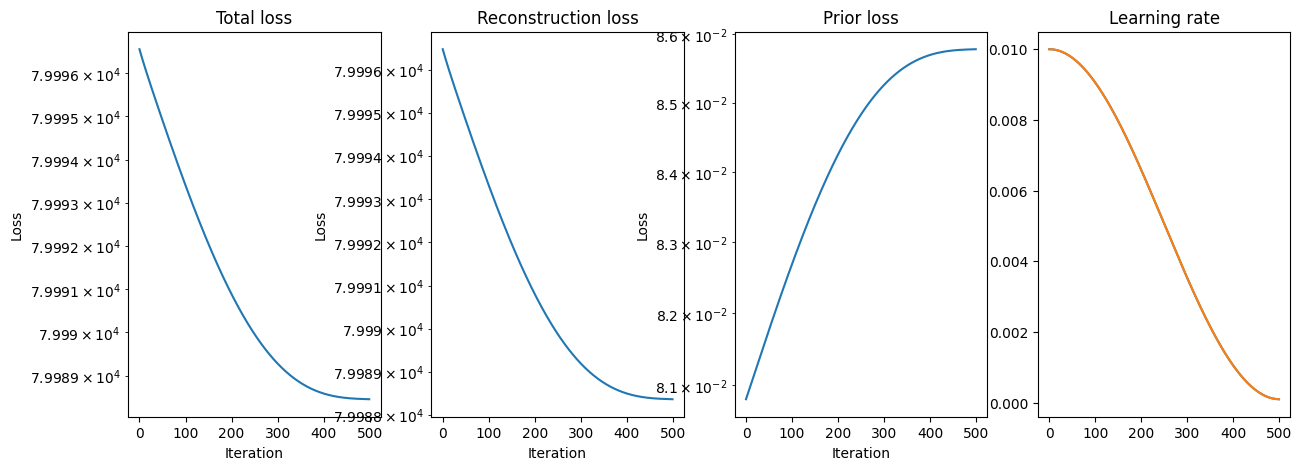

In [17]:
plot_training(loss_list, reco_loss_list, prior_loss_list, learning_rate_list_H, learning_rate_list_W)

In [18]:
reco_loss_list

[79996.4736929931,
 79996.43565579188,
 79996.39818046206,
 79996.36121583525,
 79996.32471560207,
 79996.28863785045,
 79996.25294463482,
 79996.21760159798,
 79996.18257763545,
 79996.14784457475,
 79996.11337690664,
 79996.07915153384,
 79996.04514754262,
 79996.01134599584,
 79995.97772975799,
 79995.94428331908,
 79995.91099264738,
 79995.87784505324,
 79995.8448290615,
 79995.81193430291,
 79995.77915141189,
 79995.74647193571,
 79995.71388824451,
 79995.68139346258,
 79995.64898139748,
 79995.6166464741,
 79995.58438368134,
 79995.55218852231,
 79995.52005696179,
 79995.48798538868,
 79995.45597057587,
 79995.4240096432,
 79995.39210003066,
 79995.36023946138,
 79995.32842592392,
 79995.29665764442,
 79995.26493306087,
 79995.233250813,
 79995.20160971495,
 79995.17000874248,
 79995.1384470225,
 79995.10692381127,
 79995.07543848881,
 79995.04399054349,
 79995.01257956392,
 79994.9812052313,
 79994.94986730789,
 79994.91856562883,
 79994.88730010195,
 79994.85607069466,
 79994.8

# Experiments with real data

Here we have synthetic data coming from single cell sequencing. From an original bag of SC data annotated, we have constructed a matrix $X$ of counts where the proportions of the different cell types are known. Thus marqued genes a directly derived from this construction.

In [19]:
centroids = pd.read_csv("./centroids.txt", sep="\t")  # W ground truth
marquers = pd.read_csv("genemarkers_zsc1.txt", sep="\t", header=None)  # M ground truth
marquers.rename(columns={0: "cell_type", 1: "marker"}, inplace=True)
props = pd.read_csv("PROPS.txt", sep="\t")  # H ground truth

unique_genes = centroids.index.unique()
unique_cell_types = centroids.columns.unique()

mappping_dict_genes = {gene: i for i, gene in enumerate(unique_genes)}
mappping_dict_cell_types = {cell_type: i for i, cell_type in enumerate(unique_cell_types)}

In [20]:
W_gt = centroids.to_numpy()
H_gt = props.to_numpy().T

In [21]:
X = pd.read_csv("./mix0norm.txt", sep="\t")
X.head()
X = X.to_numpy()
X = torch.from_numpy(X)

In [22]:
m, K = W_gt.shape
k = K
n = X.shape[1]

In [23]:
# construct M
M = np.zeros((m, k), dtype=bool)
for i, row in marquers.iterrows():
    gene = row["marker"]
    cell_type = row["cell_type"]
    M[mappping_dict_genes[gene], mappping_dict_cell_types[cell_type]] = True

# construct M_tilde
M_tilde = np.concatenate((M, np.ones((m, K - k))), 1)

M = torch.from_numpy(M)
M_tilde = torch.from_numpy(M_tilde)

In [24]:
def train(X, W, H, M, l, n_iter, n_iter_H, n_iter_W, optimizer_H, optimizer_W, scheduler_H, scheduler_W):
    loss_list = []
    reco_loss_list = []
    prior_loss_list = []
    std_H_list = []
    learning_rate_list_H = []
    learning_rate_list_W = []

    pbar = tqdm(range(n_iter), desc="Training")
    for t in pbar:

        for iter_h in range(n_iter_H):
            optimizer_H.zero_grad()
            loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
            loss.backward()
            optimizer_H.step()
            # H.data = projection(H.data, normalize=True)
            H.data = projection(H.data, normalize=False)
        # H.data = projection(H.data, normalize=True)

        for iter_w in range(n_iter_W):
            optimizer_W.zero_grad()
            loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
            loss.backward()
            optimizer_W.step()
            W.data = projection(W.data, normalize=False)  # -> comment this line to allow for negative weights

        scheduler_H.step()
        scheduler_W.step()

        # Logging
        loss, reco_loss, prior_loss = loss_fn(X, W, H, M, l)
        loss_list.append(loss.item())
        reco_loss_list.append(reco_loss.item())
        prior_loss_list.append(prior_loss.item())
        learning_rate_list_H.append(scheduler_H.get_last_lr()[0])
        learning_rate_list_W.append(scheduler_W.get_last_lr()[0])
        std_H = H.std()
        std_H_list.append(std_H.item())
        pbar.set_postfix(
            {
                "loss": loss.item(),
                "reconstruction error": reco_loss.item(),
                "prior loss": prior_loss.item(),
                "std_H": H.std().item(),
                "learning rate H": scheduler_H.get_last_lr()[0],
                "learning rate W": scheduler_W.get_last_lr()[0],
            }
        )

    # print("Final loss:", loss.item())
    # print(f"Final reconstruction error: {reco_loss.item()}")
    # print("Average weights magnitude on markers:", W[:, :k][M].mean().item())
    # print("Average weights magnitude on non-markers:", W[:, :k][~M].mean().item())

    return (
        W,
        H,
        loss_list,
        reco_loss_list,
        prior_loss_list,
        std_H_list,
        learning_rate_list_H,
        learning_rate_list_W,
    )

In [25]:
def grid_search(
    X,
    W_gt,
    H_gt,
    M,
    lambda_list,
    n_try,
    learning_rate_H,
    learning_rate_W,
    n_iter,
    n_iter_H,
    n_iter_W,
    init_type,
):
    dict_list = []
    for k, l in enumerate(lambda_list):
        final_reco_loss_list = []
        final_prior_loss_list = []
        final_std_H_list = []
        corr_H_list = []
        corr_W_list = []
        print(f"Trial {k}/{len(lambda_list)} Lambda: {l}")
        for _ in range(n_try):
            W, H = initialize_W_H(m, n, K, normalize=False, type=init_type, X=X)

            # Optimize
            optimizer_H = torch.optim.Adam([H], lr=learning_rate_H)
            optimizer_W = torch.optim.Adam([W], lr=learning_rate_W)
            scheduler_H = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_H, T_max=n_iter, eta_min=0.001)
            scheduler_W = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_W, T_max=n_iter, eta_min=0.001)

            (
                W,
                H,
                loss_list,
                reco_loss_list,
                prior_loss_list,
                std_H_list,
                learning_rate_list_H,
                learning_rate_list_W,
            ) = train(
                X, W, H, M, l, n_iter, n_iter_H, n_iter_W, optimizer_H, optimizer_W, scheduler_H, scheduler_W
            )
            # Correlation between the ground truth and the estimated H
            H = projection(H, normalize=True)
            H_est = H.detach().numpy()
            W_est = W.detach().numpy()
            corr_H = spearmanr(H_est.flatten(), H_gt.flatten())
            corr_W = spearmanr(W_est.flatten(), W_gt.flatten())

            final_reco_loss_list.append(reco_loss_list[-1])
            final_prior_loss_list.append(prior_loss_list[-1])
            final_std_H_list.append(std_H_list[-1])
            corr_H_list.append(corr_H.correlation)
            corr_W_list.append(corr_W.correlation)

        res_dict = {
            "Lambda": l,
            "mean_reco_loss": np.mean(final_reco_loss_list),
            "mean_prior_loss": np.mean(final_prior_loss_list),
            "mean_std_H": np.mean(final_std_H_list),
            "std_reco_loss": np.std(final_reco_loss_list),
            "std_prior_loss": np.std(final_prior_loss_list),
            "std_std_H": np.std(final_std_H_list),
            "corr_H": np.mean(corr_H_list),
            "corr_W": np.mean(corr_W_list),
            "std_corr_h": np.std(corr_H_list),
            "std_corr_w": np.std(corr_W_list),
        }

        dict_list.append(res_dict)

        print(res_dict)
        print("#" * 80, end="\n\n")

    df = pd.DataFrame(dict_list)
    return df

In [26]:
lambda_list = np.logspace(-1, 2.5, 10)
print("Lambda values:", lambda_list)
n_try = 5
learning_rate_H = learning_rate_W = 1
n_iter = 500
n_iter_H = n_iter_W = 5


start_time = datetime.now()


# recap_df_random = grid_search(
#     X,
#     W_gt,
#     H_gt,
#     M,
#     lambda_list,
#     n_try,
#     learning_rate_H,
#     learning_rate_W,
#     n_iter,
#     n_iter_H,
#     n_iter_W,
#     init_type="random",
# )
# recap_df_random.to_csv("recap_df_random.tsv", sep="\t", index=False)

# recap_df_sklearn = grid_search(
#     X,
#     W_gt,
#     H_gt,
#     M,
#     lambda_list,
#     n_try,
#     learning_rate_H,
#     learning_rate_W,
#     n_iter,
#     n_iter_H,
#     n_iter_W,
#     init_type="sklearn",
# )
# recap_df_sklearn.to_csv("recap_df_sklearn.tsv", sep="\t", index=False)


# recap_df_nndsvd = grid_search(
#     X,
#     W_gt,
#     H_gt,
#     M,
#     lambda_list,
#     n_try,
#     learning_rate_H,
#     learning_rate_W,
#     n_iter,
#     n_iter_H,
#     n_iter_W,
#     init_type="nndsvd",
# )
# recap_df_nndsvd.to_csv("recap_df_nndsvd.tsv", sep="\t", index=False)

end_time = datetime.now()
print(f"Finished at {end_time}")
print(f"Duration: {end_time - start_time}")

Lambda values: [1.00000000e-01 2.44843675e-01 5.99484250e-01 1.46779927e+00
 3.59381366e+00 8.79922544e+00 2.15443469e+01 5.27499706e+01
 1.29154967e+02 3.16227766e+02]
Finished at 2024-04-03 11:13:38.410322
Duration: 0:00:00


In [27]:
recap_df_sklearn = pd.read_csv("recap_df_sklearn.tsv", sep="\t")
recap_df_random = pd.read_csv("recap_df_random.tsv", sep="\t")
recap_df_nndsvd = pd.read_csv("recap_df_nndsvd.tsv", sep="\t")

recap_df_sklearn.sort_values(by="corr_H", ascending=False, inplace=True)
recap_df_random.sort_values(by="corr_H", ascending=False, inplace=True)
recap_df_nndsvd.sort_values(by="corr_H", ascending=False, inplace=True)

In [28]:
def plot_recap(recap_df, title="None"):
    recap_df.Lambda = recap_df.Lambda.apply(lambda x: np.round(x, 1))
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    sns.barplot(
        data=recap_df,
        x="Lambda",
        y="corr_H",
        yerr=recap_df["std_corr_h"],
        color="blue",
        ax=axes[0],
        # order=recap_df.corr_H,
    )
    axes[0].set_title("Correlation between H ground truth and H estimated")
    axes[0].set_xlabel("Lambda")
    axes[0].set_ylabel("Spearman correlation")
    # axes[0].set_ylim(0.4, 1)

    sns.barplot(data=recap_df, x="Lambda", y="corr_W", yerr=recap_df["std_corr_w"], color="red", ax=axes[1])
    axes[1].set_title("Correlation between W ground truth and W estimated")
    axes[1].set_xlabel("Lambda")
    axes[1].set_ylabel("Spearman correlation")
    # axes[1].set_ylim(0.4, 1)

    sns.barplot(
        data=recap_df,
        x="Lambda",
        y="mean_reco_loss",
        # yerr=recap_df["std_reco_loss"],
        color="green",
        ax=axes[2],
    )
    axes[2].set_title("Reconstruction error")
    axes[2].set_xlabel("Lambda")
    axes[2].set_ylabel("Reconstruction error")

    sns.barplot(
        data=recap_df,
        x="Lambda",
        y="mean_prior_loss",
        # yerr=recap_df["std_prior_loss"],
        color="orange",
        ax=axes[3],
    )
    axes[3].set_title("Prior loss")
    axes[3].set_xlabel("Lambda")
    axes[3].set_ylabel("Prior loss")

    plt.tight_layout()
    plt.suptitle(title) if title is not None else None
    plt.show()

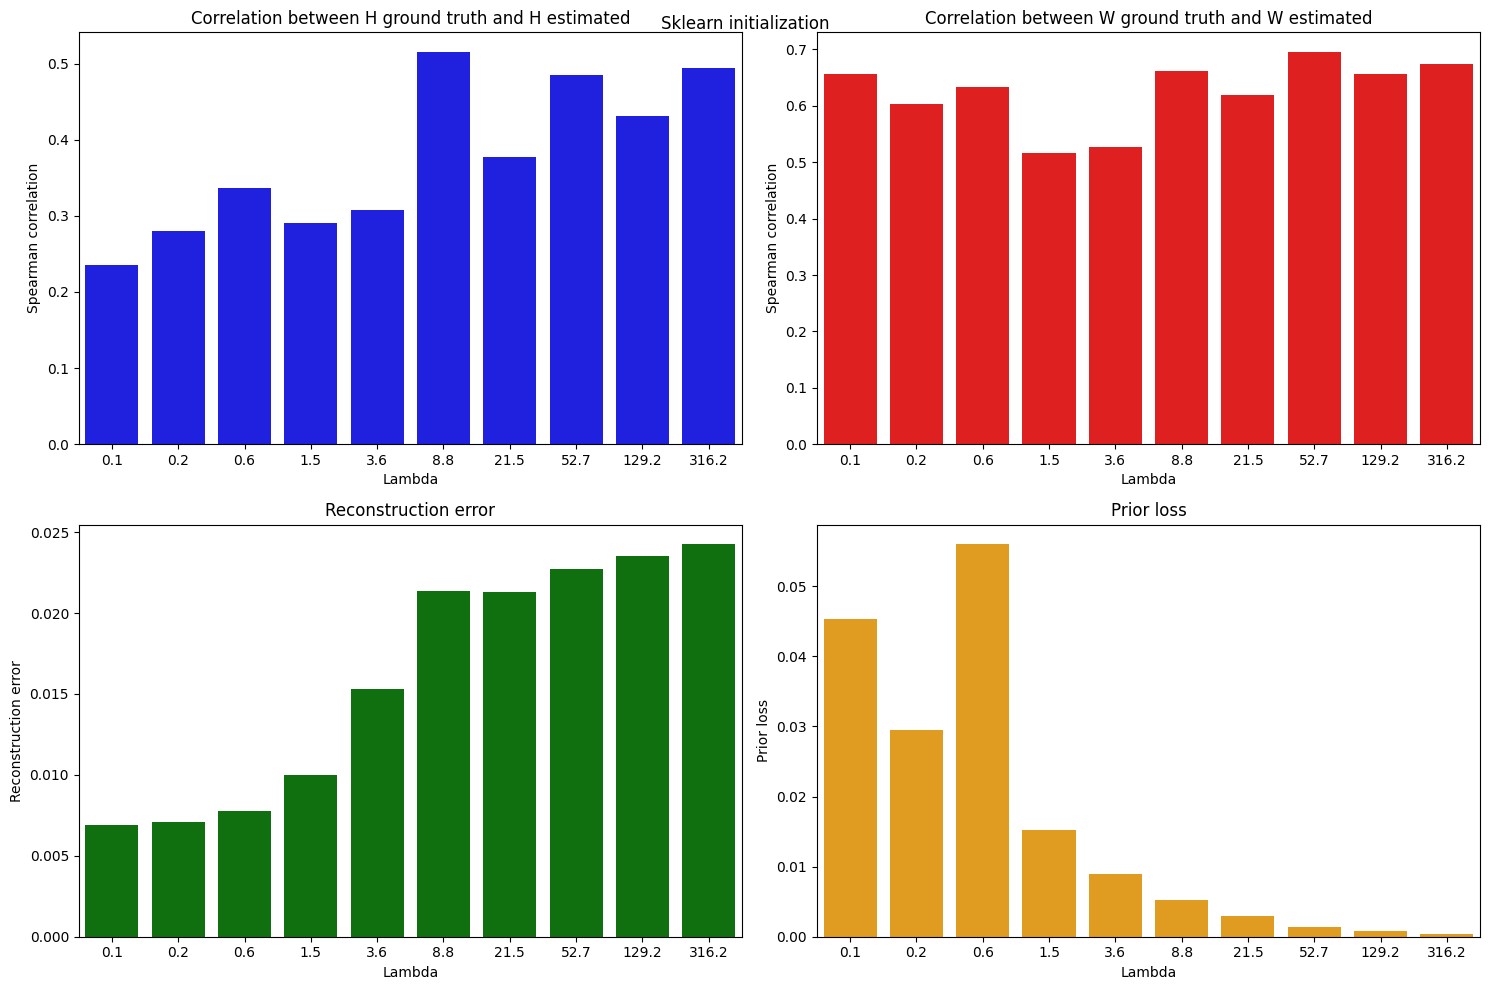

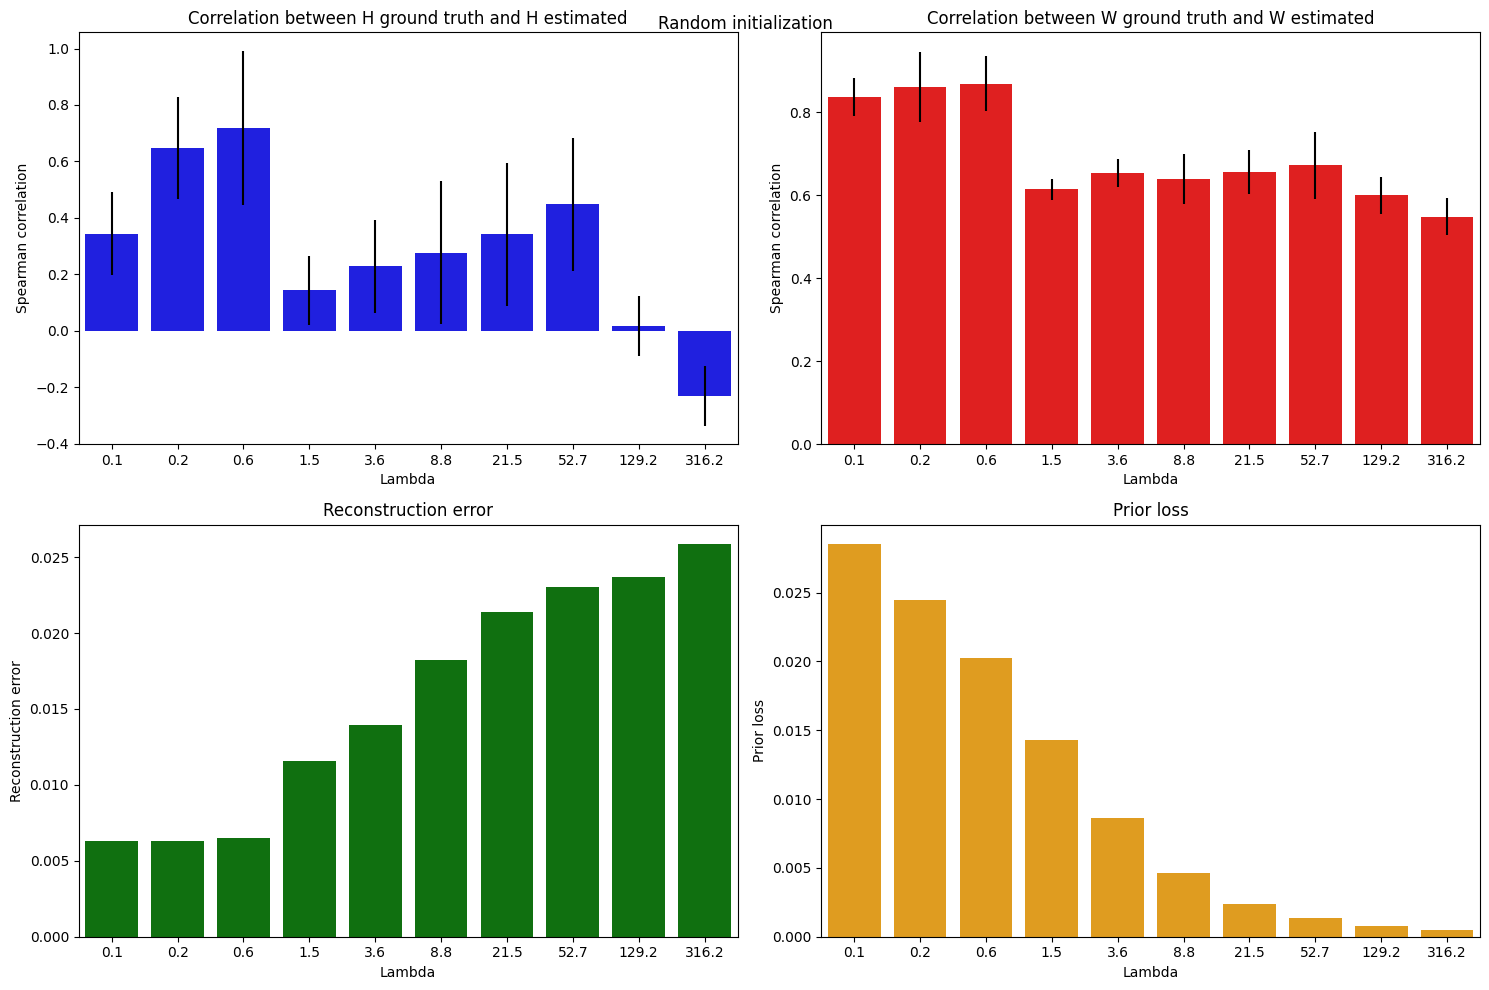

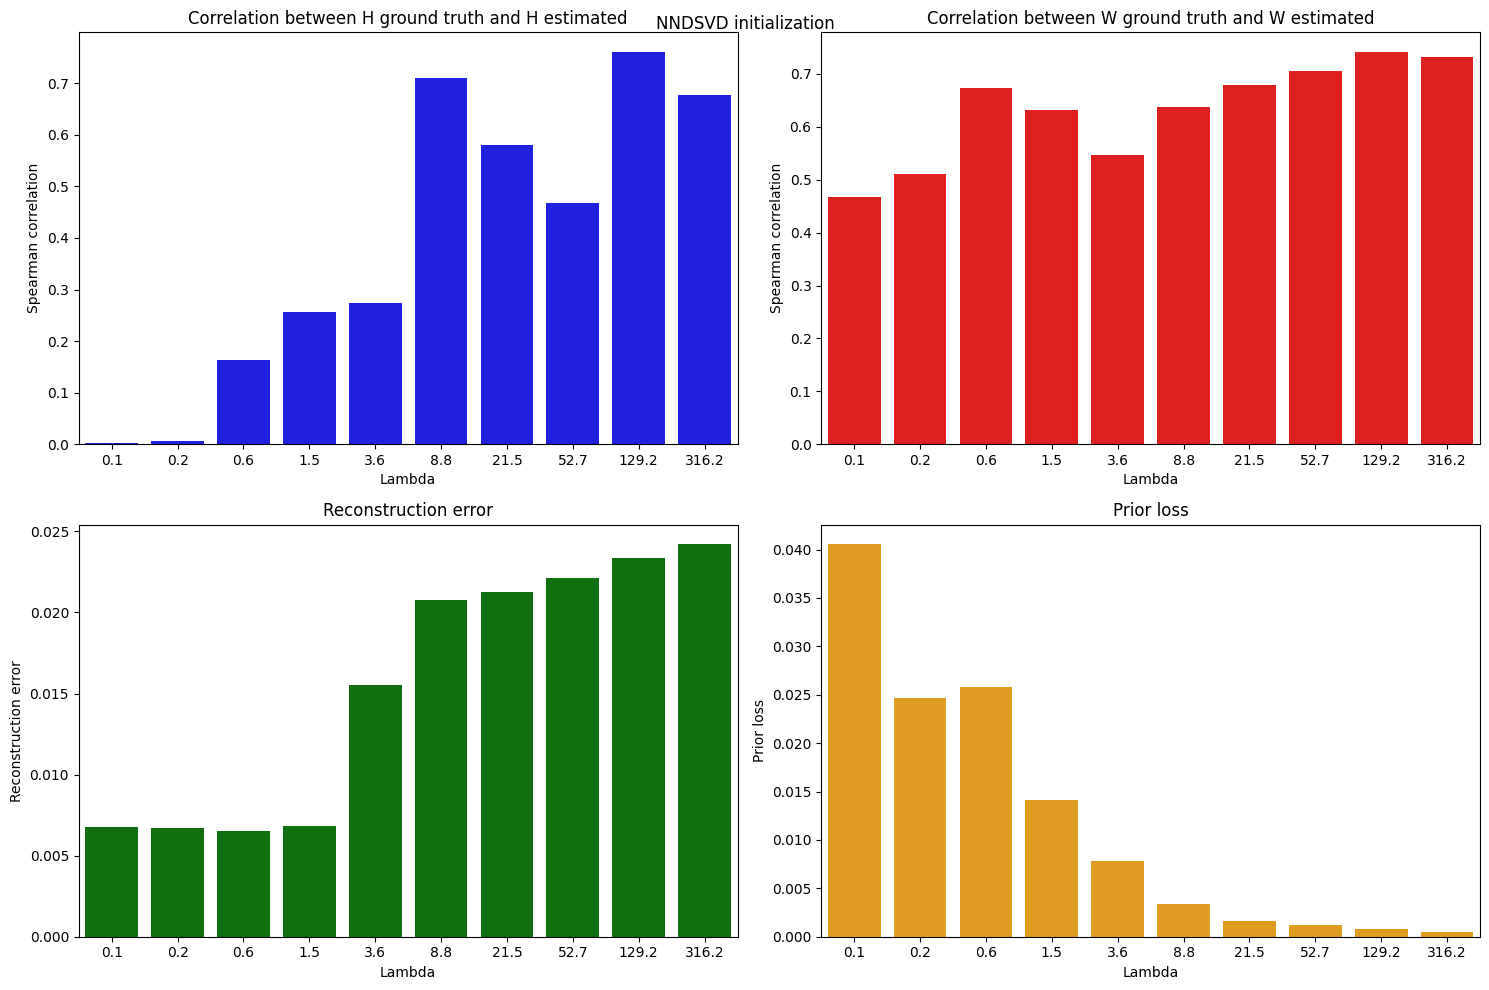

In [29]:
plot_recap(recap_df_sklearn, title="Sklearn initialization")
plot_recap(recap_df_random, title="Random initialization")
plot_recap(recap_df_nndsvd, title="NNDSVD initialization")

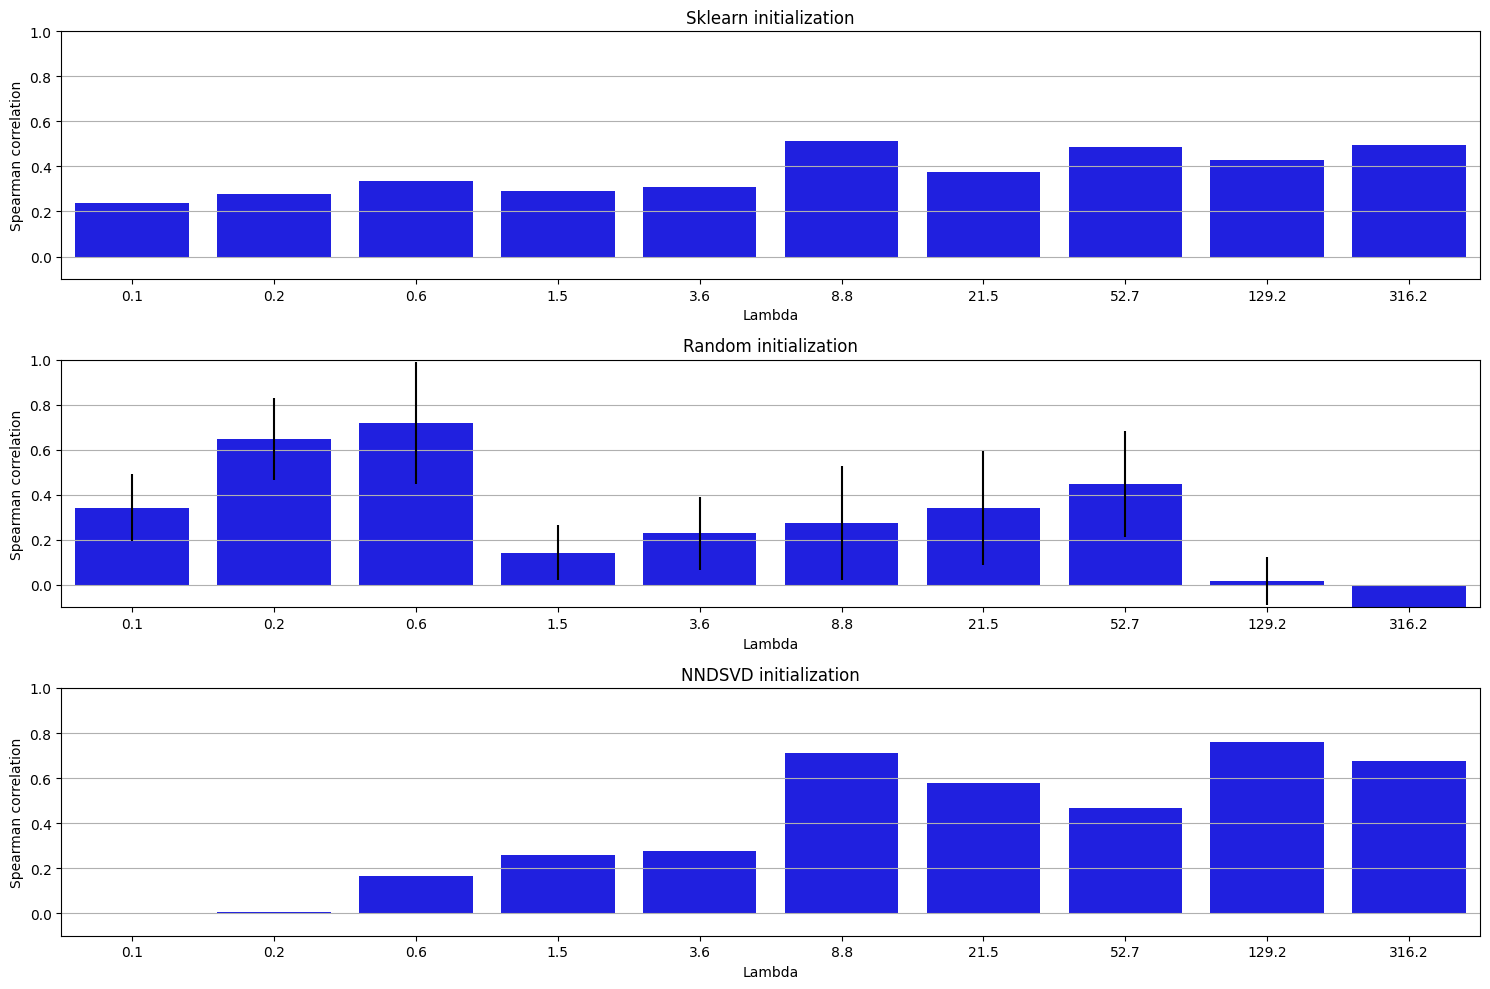

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()


def plt_corr(df, idx, title=None):
    sns.barplot(
        data=df,
        x="Lambda",
        y="corr_H",
        yerr=df["std_corr_h"],
        color="blue",
        ax=axes[idx],
        # order=recap_df.corr_H,
    )
    axes[idx].set_xlabel("Lambda")
    axes[idx].set_ylabel("Spearman correlation")
    axes[idx].set_ylim(-0.1, 1)
    axes[idx].set_title(title)
    axes[idx].grid(axis="y")


plt_corr(recap_df_sklearn, 0, "Sklearn initialization")
plt_corr(recap_df_random, 1, "Random initialization")
plt_corr(recap_df_nndsvd, 2, "NNDSVD initialization")
plt.tight_layout()